In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-m101j8wu
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-m101j8wu
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=ee863e4a62855e7b95f12d10fe42175c4a6ff346c8db72a330166f2d13282cf0
  Stored in directory: /tmp/pip-ephem-wheel-cache-olbcmax2/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
 os.chdir("/content/drive/My Drive/Utils")

In [0]:
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.resnet import ResNet18
# import model as md
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from tqdm import tqdm
from albumentation import Albumentation
from gradcam import GradCAM, visualize_cam

### Create model and display summary

In [7]:

model_obj = ResNet18(dropout=0.1)

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Get data set object

In [0]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [0]:
import albumentations as A
import albumentations.pytorch as AP

import albumentations as A

means = (0.5, 0.5, 0.5)
stdevs = (0.5, 0.5, 0.5)
customised_transforms =  [ 
                            A.HorizontalFlip(),
                            A.Normalize(mean=means, std=stdevs),
                            A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
                            AP.ToTensor() 
                         ]
train_transforms = Albumentation(transforms = customised_transforms)
test_transforms=Albumentation(transforms = [A.Normalize(mean=means, std=stdevs), AP.ToTensor() ])


### Get Train and Test data set

In [10]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [11]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=128)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

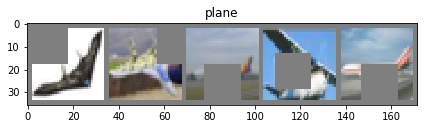

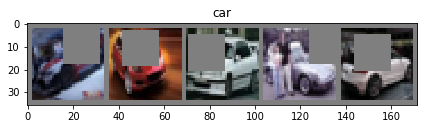

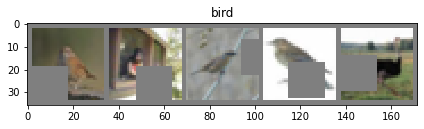

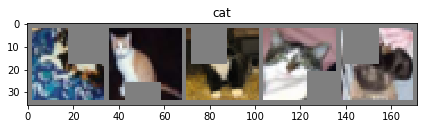

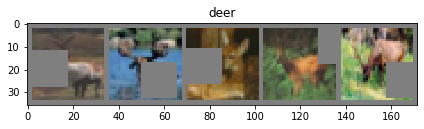

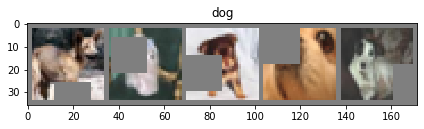

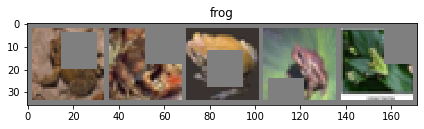

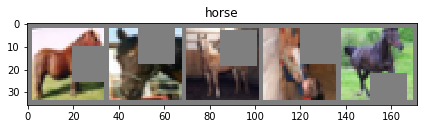

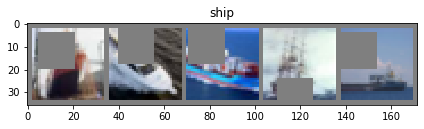

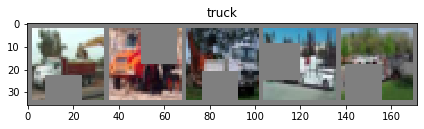

In [12]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
Plot.show_cifar_classwise_image(train_loader, classes)


### Run the model

In [13]:
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.0004, lr=0.001, momentum=0.95)
scheduler = helper_obj.get_one_cycle_lr(optimizer=optimizer, lr=0.001)
EPOCHS = 21
l1_factor=0.0001

train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []

criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS):

    print("EPOCH:", epoch)
    train_obj.train(model, device, train_loader, optimizer, criterion)
    scheduler.step()
    test_obj.test(model, device, test_loader, criterion, misclassfied_required=True)

    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])

misclassified_images = test_obj.misclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
correct_classified_images = test_obj.trueclassified_images
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=1.4664568901062012 Batch_id=390 Accuracy=38.06: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 4977/10000 (49.77%)

EPOCH: 2


Train Set: Train Loss=1.0896867513656616 Batch_id=390 Accuracy=51.59: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 5838/10000 (58.38%)

EPOCH: 3


Train Set: Train Loss=0.8010843992233276 Batch_id=390 Accuracy=58.61: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 6660/10000 (66.60%)

EPOCH: 4


Train Set: Train Loss=0.8838208317756653 Batch_id=390 Accuracy=64.82: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 6655/10000 (66.55%)

EPOCH: 5


Train Set: Train Loss=1.2310611009597778 Batch_id=390 Accuracy=69.19: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7349/10000 (73.49%)

EPOCH: 6


Train Set: Train Loss=0.9033299684524536 Batch_id=390 Accuracy=72.08: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7473/10000 (74.73%)

EPOCH: 7


Train Set: Train Loss=0.7393391132354736 Batch_id=390 Accuracy=74.24: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7661/10000 (76.61%)

EPOCH: 8


Train Set: Train Loss=0.6083083748817444 Batch_id=390 Accuracy=75.88: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7885/10000 (78.85%)

EPOCH: 9


Train Set: Train Loss=0.5999247431755066 Batch_id=390 Accuracy=77.45: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8065/10000 (80.65%)

EPOCH: 10


Train Set: Train Loss=0.566753625869751 Batch_id=390 Accuracy=78.29: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 7611/10000 (76.11%)

EPOCH: 11


Train Set: Train Loss=0.6578526496887207 Batch_id=390 Accuracy=79.54: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8322/10000 (83.22%)

EPOCH: 12


Train Set: Train Loss=0.6758645176887512 Batch_id=390 Accuracy=80.34: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7459/10000 (74.59%)

EPOCH: 13


Train Set: Train Loss=0.7148979902267456 Batch_id=390 Accuracy=81.54: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8313/10000 (83.13%)

EPOCH: 14


Train Set: Train Loss=0.4712854027748108 Batch_id=390 Accuracy=82.54: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8266/10000 (82.66%)

EPOCH: 15


Train Set: Train Loss=0.4996446967124939 Batch_id=390 Accuracy=83.96: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8531/10000 (85.31%)

EPOCH: 16


Train Set: Train Loss=0.4804334044456482 Batch_id=390 Accuracy=85.40: 100%|██████████| 391/391 [00:35<00:00, 11.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8674/10000 (86.74%)

EPOCH: 17


Train Set: Train Loss=0.30191224813461304 Batch_id=390 Accuracy=86.99: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8886/10000 (88.86%)

EPOCH: 18


Train Set: Train Loss=0.2115764170885086 Batch_id=390 Accuracy=88.33: 100%|██████████| 391/391 [00:35<00:00, 11.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 8997/10000 (89.97%)

EPOCH: 19


Train Set: Train Loss=0.356238454580307 Batch_id=390 Accuracy=89.55: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9030/10000 (90.30%)

EPOCH: 20


Train Set: Train Loss=0.4180730879306793 Batch_id=390 Accuracy=90.03: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 0.0022, Accuracy: 9058/10000 (90.58%)

Maximum Training Accuracy =  90.03
Maximum Testing Accuracy =  90.58


### Display graphs

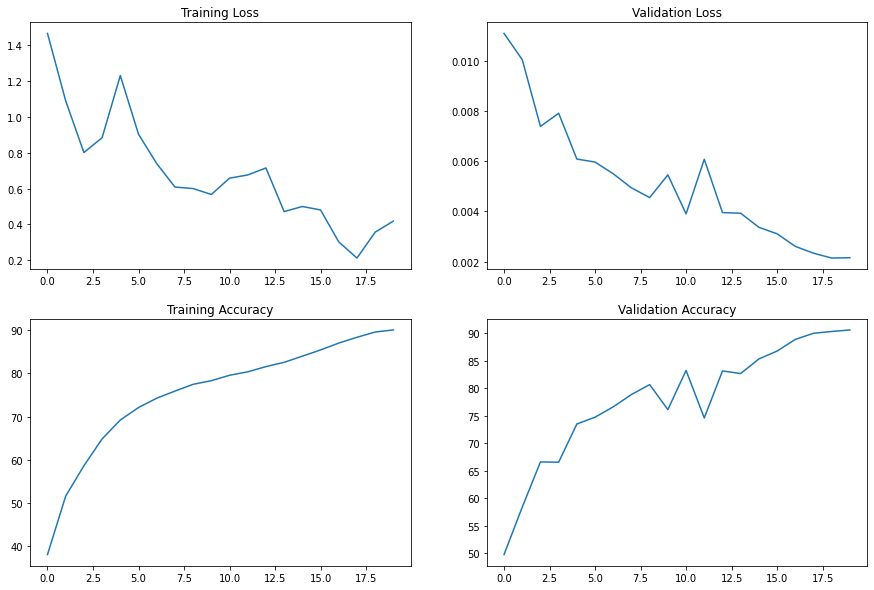

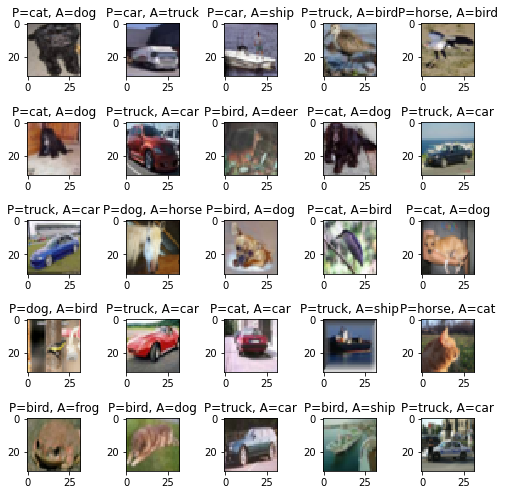

In [14]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
plt_obj.display_all_plot()
plt_obj.plot_cifar_misclassified(misclassified_images)

###Visualizing gradcam results for correctly classified images in layer4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


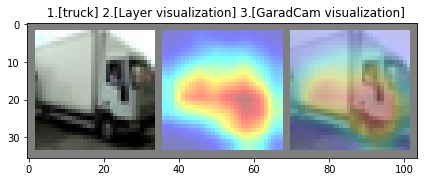

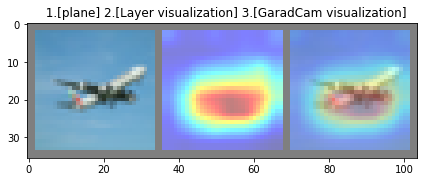

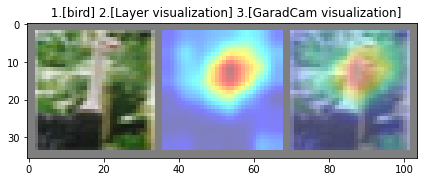

In [15]:
from torchvision.utils import make_grid
num_img = 3
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([correct_classified_images[index][0]]))
  heatmap, result = visualize_cam(mask, correct_classified_images[index][0])
  images.extend([correct_classified_images[index][0].cpu(), heatmap, result])
  label = "  1.[{0}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[correct_classified_images[index][2].item()])
  Plot.image_show(make_grid(images, nrow=5), title=label)

###Visualizing Gradcam results for correct classified images in all 4 layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


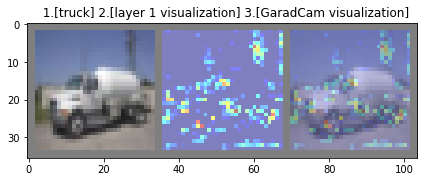

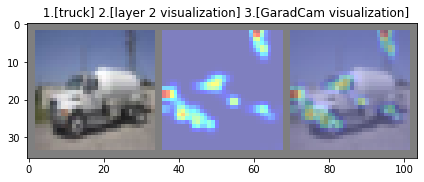

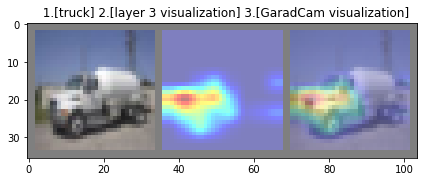

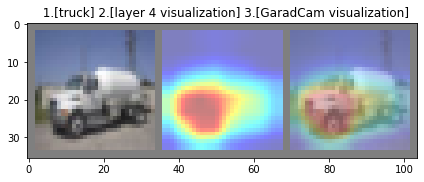

In [16]:
from torchvision.utils import make_grid
image = correct_classified_images[7] #take one random image from correctly classidfied images
layer_details = [model.layer1, model.layer2, model.layer3, model.layer4]
for i, model_layer in enumerate(layer_details):
    images = []
    grad_cam = GradCAM(model, model_layer)
    mask, _ = grad_cam(torch.stack([image[0]]))
    heatmap, result = visualize_cam(mask, image[0])
    images.extend([image[0].cpu(), heatmap, result])
    label = "  1.[{0}] 2.[layer {1} visualization] 3.[GaradCam visualization]".format(classes[image[2].item()], i+1)
    Plot.image_show(make_grid(images, nrow=5), title=label)

###Visualizing Gradcam results for miss classified images in layer 4

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


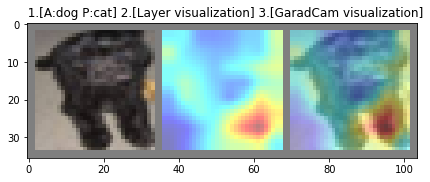

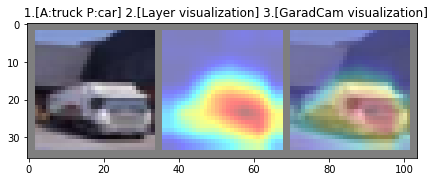

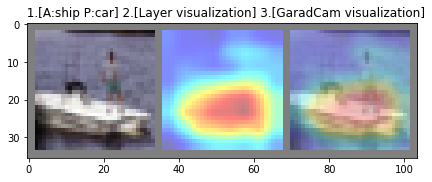

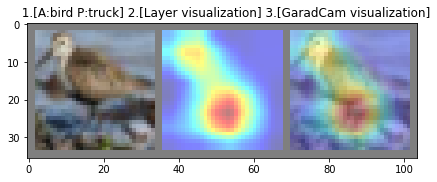

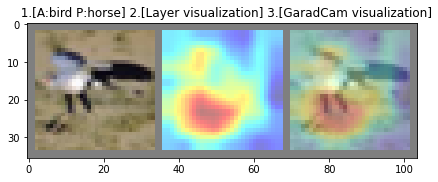

In [17]:
num_img = 5
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([misclassified_images[index][0]]))
  heatmap, result = visualize_cam(mask, misclassified_images[index][0])
  images.extend([misclassified_images[index][0].cpu(), heatmap, result])
  label = "  1.[A:{0} P:{1}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[misclassified_images[index][2].item()],classes[misclassified_images[index][1].item()])
  Plot.image_show(make_grid(images, nrow=5), title=label)